# Import PDK

## Import PDK from GDS files

To import a PDK from GDS files into gdsfactory you need:

- GDS file with all the cells that you want to import in the PDK (or separate GDS files, where each file contains a GDS design).

Ideally you also get:

- Klayout layer properties files, to define the Layers that you can use when creating new custom Components. This allows you to define the LayerMap that maps Layer_name to (GDS_LAYER, GDS_PuRPOSE).
- layer_stack information (material index, thickness, z positions of each layer).
- DRC rules. If you don't get this you can easily build one using klayout.

GDS files are great for describing geometry thanks to the concept of References, where you store any geometry only once in memory.

For storing device metadata (settings, port locations, port widths, port angles ...) there is no clear standard.

`gdsfactory` stores the that metadata in `YAML` files, and also has functions to add pins

- `Component.write_gds()` saves GDS

In [ ]:
import gdsfactory as gf
from gdsfactory.config import PATH
from gdsfactory.technology import lyp_to_dataclass

2025-03-27 14:59:11.025 | INFO     | gdsfactory.labels.write_labels:write_labels:92 - Wrote 0 labels to CSV PosixPath('/home/nynra/repos/pytools-lithography/pytools-litho-design/gdsfactory-UL-main/notebooks/extra/pdk.csv')


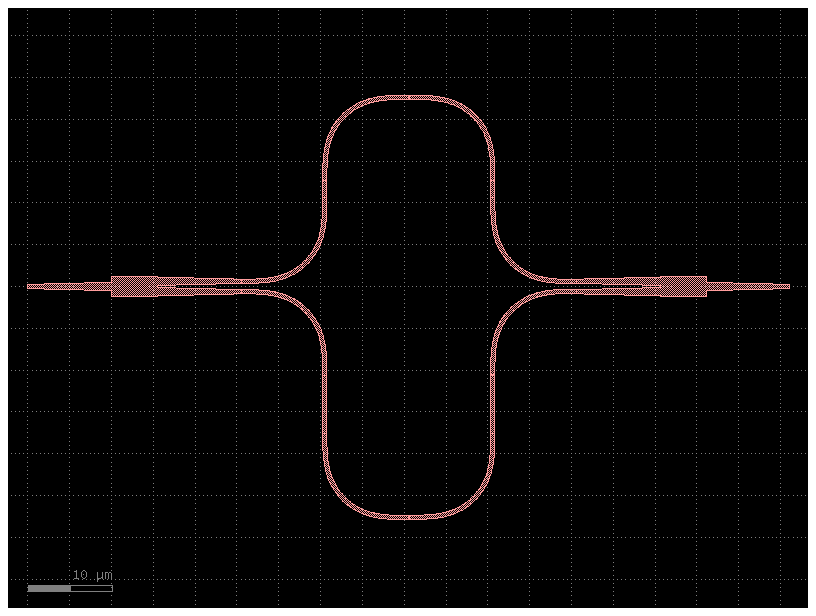

In [2]:
c = gf.components.mzi()
c.plot()

You can write **GDS**  files.

In [3]:
gdspath = c.write_gds("extra/mzi.gds")

In [4]:
c.pprint_ports()

┏━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ name ┃ width ┃ orientation ┃ layer    ┃ center                   ┃ port_type ┃
┡━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ o1   │ 0.5   │ 180.0       │ WG (1/0) │ (-10.0, 0.0)             │ optical   │
│ o2   │ 0.5   │ 0.0         │ WG (1/0) │ (81.10000000000001, 0.0) │ optical   │
└──────┴───────┴─────────────┴──────────┴──────────────────────────┴───────────┘

You can read GDS files into gdsfactory thanks to the `import_gds` function

`import_gds` reads the same GDS file from disk without losing any information. 

Gdsfactory stores the settings and the ports as part of the GDS metadata

┏━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ name ┃ width ┃ orientation ┃ layer    ┃ center                   ┃ port_type ┃
┡━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ o1   │ 0.5   │ 180.0       │ WG (1/0) │ (-10.0, 0.0)             │ optical   │
│ o2   │ 0.5   │ 0.0         │ WG (1/0) │ (81.10000000000001, 0.0) │ optical   │
└──────┴───────┴─────────────┴──────────┴──────────────────────────┴───────────┘

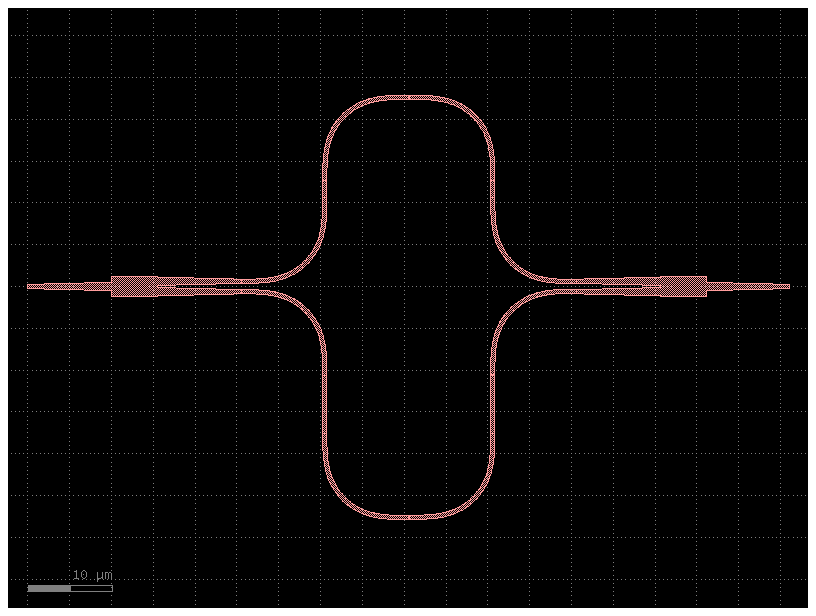

In [5]:
c = gf.import_gds(gdspath)
c.pprint_ports()
c.plot()

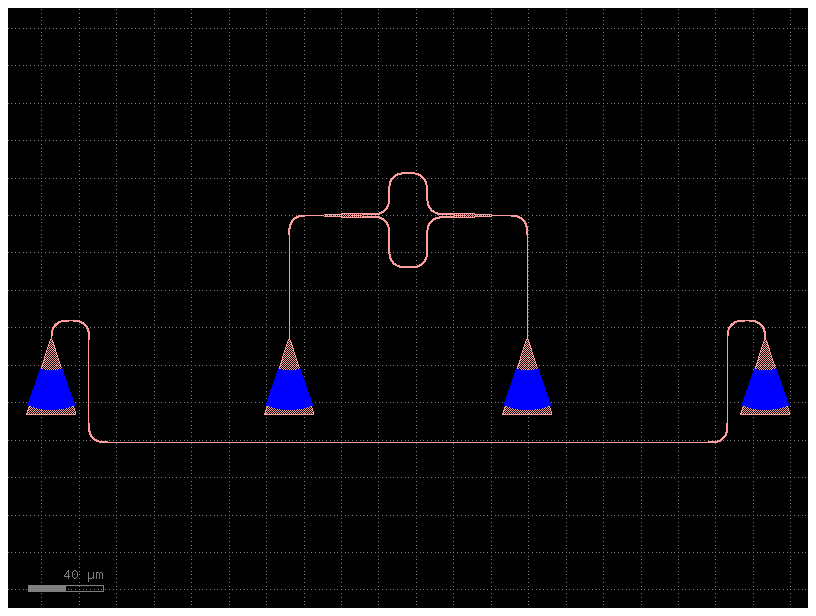

In [6]:
c3 = gf.routing.add_fiber_array(c)
c3.plot()

In [7]:
gdspath = c3.write_gds("extra/pdk.gds")

In [8]:
gf.labels.write_labels(gdspath, layer_label=(201, 0))

PosixPath('extra/pdk.csv')

### add ports from pins

Sometimes the GDS does not have YAML metadata, therefore you need to figure out the port locations, widths and orientations.

gdsfactory provides you with functions that will add ports to the component by looking for pins shapes on a specific layers (port_markers or pins)

There are different pin standards supported to automatically add ports to components:

- PINs towards the inside of the port (port at the outer part of the PIN)
- PINs with half of the pin inside and half outside (port at the center of the PIN)
- PIN with only labels (no shapes). You have to manually specify the width of the port.


Lets add pins, save a GDS and then import it back.

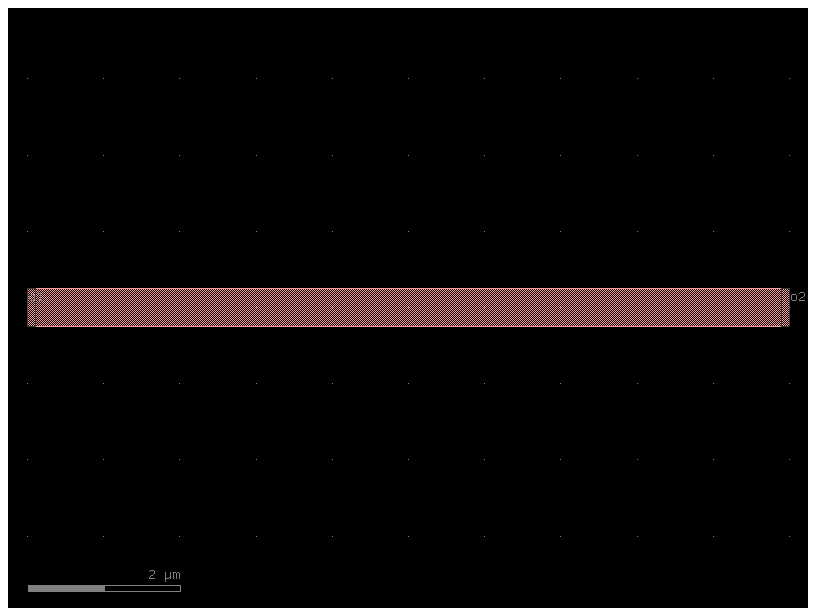

In [9]:
c = gf.components.straight()
c_with_pins = gf.add_pins.add_pins_container(component=c)
c_with_pins.plot()

In [10]:
c_with_pins.ports = []  # lets rely on the pins to extract the ports
gdspath = c_with_pins.write_gds("extra/wg.gds")

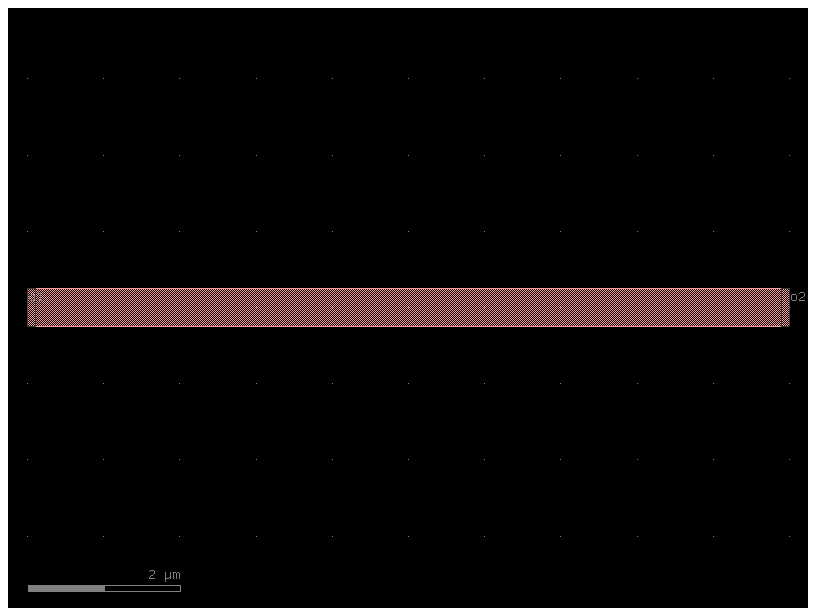

In [11]:
c2 = gf.import_gds(gdspath)
c2.plot()

In [12]:
c2.ports  # import_gds does not automatically add the pins

[]

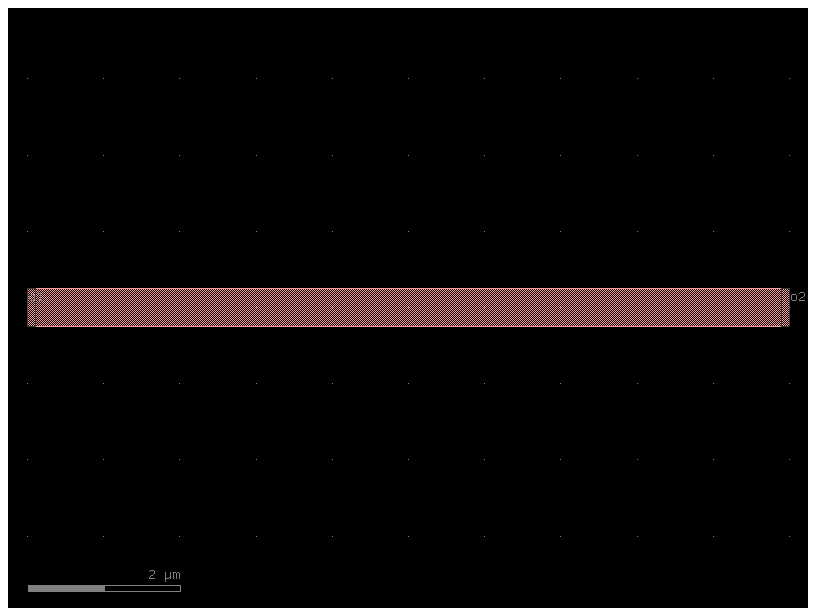

In [13]:
c3 = gf.import_gds(gdspath)
c3 = gf.add_ports.add_ports_from_markers_inside(c3, pin_layer="PORT")
c3.plot()

In [14]:
c3.pprint_ports()

┏━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ name ┃ width ┃ orientation ┃ layer         ┃ center      ┃ port_type ┃
┡━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ o1   │ 0.5   │ 180.0       │ WG_PIN (1/10) │ (0.0, 0.0)  │ optical   │
│ o2   │ 0.5   │ 0.0         │ WG_PIN (1/10) │ (10.0, 0.0) │ optical   │
└──────┴───────┴─────────────┴───────────────┴─────────────┴───────────┘

Foundries provide PDKs in different formats and commercial tools.

The easiest way to import a PDK into gdsfactory is to:

1. have each GDS cell into a separate GDS file
2. have one GDS file with all the cells inside
3. Have a KLayout layermap. Makes easier to create the layermap.

With that you can easily create the PDK as as python package.

Thanks to having a gdsfactory PDK as a python package you can:

- version control your PDK using GIT to keep track of changes and work on a team
    - write tests of your pdk components to avoid unwanted changes from one component to another.
    - ensure you maintain the quality of the PDK with continuous integration checks
    - pin the version of gdsfactory, so new updates of gdsfactory won't affect your code
- name your PDK version using [semantic versioning](https://semver.org/). For example patches increase the last number (0.0.1 -> 0.0.2)
- install your PDK easily `pip install pdk_fab_a` and easily interface with other tools



To create a **Python** package you can start from a customizable template (thanks to cookiecutter)

You can create a python package by running this 2 commands inside a terminal:

```
pip install cookiecutter
cookiecutter gh:joamatab/python
```

It will ask you some questions to fill in the template for the python package.


Then you can add the information about the GDS files and the Layers inside that package

In [15]:
print(lyp_to_dataclass(PATH.klayout_lyp))


from gdsfactory.typings import Layer
from gdsfactory.technology.layer_map import LayerMap


class LayerMapFab(LayerMap):
    CAPACITOR: Layer = (42, 0)
    DEEPTRENCH: Layer = (4, 0)
    DEEP_ETCH: Layer = (3, 6)
    DICING: Layer = (65, 0)
    DRC_EXCLUDE: Layer = (67, 0)
    DRC_MARKER: Layer = (205, 0)
    DevRec: Layer = (68, 0)
    ERROR_PATH: Layer = (1000, 0)
    Errors: Layer = (69, 0)
    FLOORPLAN: Layer = (64, 0)
    FbrTgt: Layer = (81, 0)
    GE: Layer = (5, 0)
    GENPP: Layer = (26, 0)
    GEPPP: Layer = (29, 0)
    LABEL_INSTANCES: Layer = (206, 0)
    LABEL_OPTICAL_IO: Layer = (201, 0)
    LABEL_SETTINGS: Layer = (202, 0)
    Lumerical: Layer = (733, 0)
    M1: Layer = (41, 0)
    M1TILES: Layer = (191, 0)
    M2: Layer = (45, 0)
    M3: Layer = (49, 0)
    METALOPEN: Layer = (46, 0)
    MH: Layer = (47, 0)
    MONITOR: Layer = (101, 0)
    N: Layer = (20, 0)
    NOTILE_M1: Layer = (71, 0)
    NOTILE_M2: Layer = (72, 0)
    NOTILE_M3: Layer = (73, 0)
    NP: Layer = (

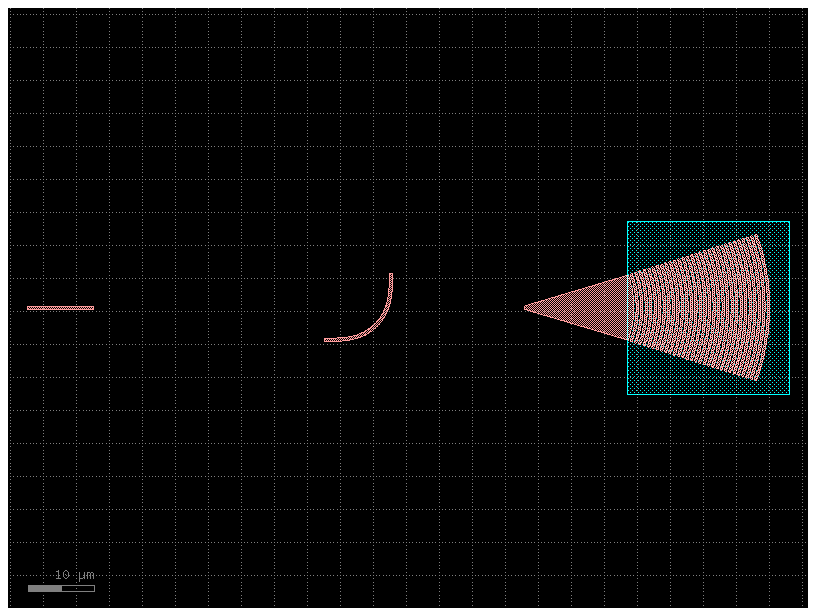

In [ ]:
# lets create a sample PDK (for demo purposes only) using GDSfactory
# if the PDK is in a commercial tool you can also do this. Make sure you save a single pdk.gds

sample_pdk_cells = gf.grid(
    (
        gf.components.straight,
        gf.components.bend_euler,
        gf.components.grating_coupler_elliptical
    )
)
sample_pdk_cells.write_gds("extra/pdk.gds")
sample_pdk_cells

In [17]:
# we write the sample PDK into a single GDS file
gf.write_cells.write_cells_recursively(gdspath="extra/pdk.gds", dirpath="extra/gds")

LockedError: 'grating_coupler_ellipti_07e69d9a' is locked and likely stored in cache. Modifications are disabled as its associated function is decorated with `cell`. To modify, update the code in the function or create a copy of the KCell.

In [18]:
print(gf.write_cells.get_import_gds_script("extra/gds"))

ValueError: '/home/nynra/repos/pytools-lithography/pytools-litho-design/gdsfactory-UL-main/notebooks/extra/gds' does not exist.

You can also include the code to plot each fix cell in the docstring.

In [19]:
print(gf.write_cells.get_import_gds_script("extra/gds", module="samplepdk.components"))

ValueError: '/home/nynra/repos/pytools-lithography/pytools-litho-design/gdsfactory-UL-main/notebooks/extra/gds' does not exist.

## Import PDK from other python packages

You can Write the cells to GDS and use the

Ideally you also start transitioning your legacy code Pcells into gdsfactory syntax. It's a great way to learn the gdsfactory way!

Here is some advice:

- Ask your foundry for the gdsfactory PDK.
- Leverage the generic pdk cells available in gdsfactory.
- Write tests for your cells.
- Break the cells into small reusable functions.
- use GIT to track changes.
- review your code with your colleagues and other gdsfactory developers to get feedback. This is key to get better at coding gdsfactory.
- get rid of any warnings you see.

## Import PDK from YAML uPDK

gdsfactory supports read and write to [uPDK YAML definition](https://openepda.org/index.html)

Lets write a PDK into uPDK YAML definition and then convert it back to a gdsfactory script.

the uPDK extracts the code from the docstrings.

```python

def evanescent_coupler_sample() -> None:
    """Evanescent coupler example.

    Args:
      coupler_length: length of coupling (min: 0.0, max: 200.0, um).
    """
    pass

```

In [20]:
from gdsfactory.samples.pdk.fab_c import PDK

PDK.activate()
yaml_pdk = PDK.to_updk()
print(yaml_pdk)

blocks:
  bend_euler_nc:
    bbox:
    - - -3.0
      - -3.5
    - - 13.5
      - -3.5
    - - 13.5
      - 10.0
    - - -3.0
      - 10.0
    doc: Canvas where you add polygons, instances and ports.
    parameters:
      cross_section:
        doc: null
        max: 0
        min: 0
        type: str
        unit: null
        value: strip_nc
    pins:
      o1:
        alias: null
        doc: null
        width: 1.0
        xsection: 7a93073b_1000
        xya:
        - 0.0
        - 0.0
        - 180.0
      o2:
        alias: null
        doc: null
        width: 1.0
        xsection: 7a93073b_1000
        xya:
        - 10.0
        - 10.0
        - 90.0
    settings:
      Properties:
        doc: ''
        max: 0
        min: 0
        type: float
        unit: null
        value: 0.0
      info:
        doc: dictionary that includes derived properties, simulation_settings, settings
        max: 0
        min: 0
        type: float
        unit: null
        value: 0.0
  bend_

In [21]:
from gdsfactory.component import GDSDIR_TEMP
from gdsfactory.read.from_updk import from_updk

yamlpath = GDSDIR_TEMP / "pdk.yml"
yamlpath.write_text(yaml_pdk)
gdsfactory_script = from_updk(yamlpath)
print(gdsfactory_script)



import sys
from functools import partial
import gdsfactory as gf
from gdsfactory.get_factories import get_cells
from gdsfactory.add_pins import add_pins_inside2um

cell = gf.cell
layer_bbox = (68, 0)
layer_bbmetal = None
layer_pin_label = None
layer_pin = None
layer_pin_optical = None
layer_pin_electrical = None
layer_label = None

layer_text = (1, 0)
text_function = partial(gf.components.text, layer=layer_text, justify="center", size=2.0)

add_pins = partial(add_pins_inside2um, layer_label=layer_label, layer=layer_pin_optical)
strip_nc = gf.CrossSection(width=1.0)
strip_no = gf.CrossSection(width=0.9)
strip_sc = gf.CrossSection(width=0.5)
strip_so = gf.CrossSection(width=0.4)

cross_sections = dict(strip_nc=strip_nc,strip_no=strip_no,strip_sc=strip_sc,strip_so=strip_so)

@gf.cell
def bend_euler_nc(cross_section:str=strip_nc)->gf.Component:
    """Canvas where you add polygons, instances and ports.

    Args:
      cross_section: None (min: 0, max: 0, None).
    
    .. plot::
      

## Build your own PDK

You can create a PDK as a python library using a cookiecutter template. For example, you can use this one.

```
pip install cookiecutter
cookiecutter gh:joamatab/python
```

Or you can fork the ubcpdk and create new PCell functions that use the correct layers for your foundry. For example.

```python

from gdsfactory.technology import LayerMap


class LayerMap(LayerMap):
    WGCORE = (3, 0)
    DEVREC: Layer = (68, 0)
    PORT: Layer = (1, 10)  # PinRec
    PORTE: Layer = (1, 11)  # PinRecM
    FLOORPLAN: Layer = (99, 0)

    TE: Layer = (203, 0)
    TM: Layer = (204, 0)
    TEXT: Layer = (66, 0)
    LABEL_INSTANCE: Layer = (66, 0)


LAYER = LayerMap

```